## Importação das Bibliotecas

In [1]:
# Pacotes de manipulação de dados
import numpy as np
import pandas as pd

# Configuração de caminho para importar módulos locais
import sys
import os

# Adiciona a pasta 'analysis' ao sys.path
sys.path.append(os.path.abspath('../analysis'))

# Pacotes gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from composicao_estatisticas import grafico_residuos

# Pacotes de modelagem
import statsmodels.api as sm
from scipy.stats import pearsonr

## Importação e tratamento da base de dados

In [2]:
# Carregar os dados do arquivo Excel
df = pd.read_excel('../data/base_salarios.xlsx')

In [3]:
# Exibir o número de linhas e colunas
print('Número de linhas e colunas:')
print(df.shape)

Número de linhas e colunas:
(46, 6)


In [4]:
# Exibir as primeiras linhas dos dados
df.head(8)

,Núm. Funcionário,Salario,Anos de Educação Superior,Tempo na Empresa,Tempo de Experiencia em outras empresas,Inglês
0,29,4139.5,0,0,11,Não
1,19,4331.1,0,6,1,Não
2,38,4629.1,2,1,6,Não
3,26,4645.9,0,5,4,Não
4,17,4651.2,2,0,6,Não
5,20,5072.4,4,0,6,Não
6,44,5170.9,1,5,9,Não
7,34,5228.3,3,2,2,Não


In [5]:
# Remover as colunas desnecessárias
columns_to_drop = ['Núm. Funcionário']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=columns_to_drop, inplace=True)


# Renomear as colunas conforme especificado
df.rename(columns={
    'Salario': 'Salario',
    'Anos de Educação Superior': 'Anos_Educ_Superior',
    'Tempo na Empresa': 'Tempo_Empresa',
    'Tempo de Experiencia em outras empresas': 'Tempo_Outras_Empresas',
    'Inglês': 'Ingles'
}, inplace=True)

## Preparação dos Dados

### Criando variáveis Dummy

In [6]:
# Amostra de dados da base
df.sample(5, random_state=42)

,Salario,Anos_Educ_Superior,Tempo_Empresa,Tempo_Outras_Empresas,Ingles
39,9316.0,6,25,3,Sim
25,6570.9,4,19,1,Não
26,6788.4,5,21,1,Não
44,11974.4,12,25,4,Sim
35,8086.9,6,14,3,Sim


In [7]:
# Criação da variável dummy usando o get_dummies()
df2 = pd.get_dummies(df, drop_first=True)

# Converter True/False para 1/0
df2 = df2.astype(int)

df2.sample(5, random_state=42)
# df.head()

,Salario,Anos_Educ_Superior,Tempo_Empresa,Tempo_Outras_Empresas,Ingles_Sim
39,9316,6,25,3,1
25,6570,4,19,1,0
26,6788,5,21,1,0
44,11974,12,25,4,1
35,8086,6,14,3,1


## Ajuste do Modelo de Regressão 
Usando o Statsmodels (Pacote de Modelos Estatísticos)

In [8]:
# Visualização das 5 primeiras linhas do df2
df2.head()

,Salario,Anos_Educ_Superior,Tempo_Empresa,Tempo_Outras_Empresas,Ingles_Sim
0,4139,0,0,11,0
1,4331,0,6,1,0
2,4629,2,1,6,0
3,4645,0,5,4,0
4,4651,2,0,6,0


In [9]:
# Variável resposta
y = df2['Salario']

# Variáveis explicativas
df2['intercepto'] = 1 

x = df2[['intercepto',
         'Anos_Educ_Superior',
         'Tempo_Empresa',
         'Tempo_Outras_Empresas',
         'Ingles_Sim']]

In [10]:
# Ajusta o modelo e retorna os resultados
modelo = sm.OLS(y , x)
resultado = modelo.fit()
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                Salario   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     67.72
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           1.62e-17
Time:                        13:37:32   Log-Likelihood:                -365.98
No. Observations:                  46   AIC:                             742.0
Df Residuals:                      41   BIC:                             751.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercepto             4422.45

**O que é o p-valor?**

O p-valor é uma medida estatística usada para ajudar a decidir se os resultados observados (as variáveis analisadas) em um experimento são significativos ou não. Para isso, comparamos os dados coletados com uma **hipótese nula**.

**O que é a hipótese nula?** 

A hipótese nula é a suposição de que não há efeito ou não há diferença entre as variáveis analisadas. Exemplo: "O tempo trabalhado em outras empresas não afeta o salário".

**Como interpretar o p-valor?**
- p < 0.05 (5%): Rejeitamos a hipótese nula. A variável tem efeito significativo.

- p >= 0.05 (5%): Não rejeitamos a hipótese nula. A variável não tem efeito significativo.

In [11]:
from IPython.display import display, HTML

# Exibir os p-valores com cores e significância
for var, p in resultado.pvalues.items():
    p_percentual = p * 100  # Convertendo para percentual
    if p < 0.05:
        cor = '#1d8a2a'  # Verde para significante
        mensagem = "Passou no teste"
    else:
        cor = '#e76f6f'  # Vermelho para não significante
        mensagem = "Não passou no teste"
    
    resultado_texto = f"<b>{var}:</b> p-valor = {p_percentual:.2f}% <span style='color:{cor}; font-style:italic;'>({mensagem})</span>"

    # Exibindo com a cor correspondente
    display(HTML(f'<div style="font-size:14px; color:#333; padding-bottom:5px;">{resultado_texto}</div>'))

Considerando que uma variável que tem um p-valor superior a 5 não é estatisticamente significativa, **Tempo_Outras_Empresas** apresentou um p-valor acima desse limite, indicando que não há evidências suficientes para afirmar que ela afeta o salário de forma consistente. Por isso, foi excluída do modelo para focarmos nas variáveis que realmente influenciam o salário.

## Novo Ajuste do Modelo de Regressão
Sem a variável Tempo_Outras_Empresas

In [12]:
# Variável resposta
y = df2['Salario']

# Variáveis explicativas
df2['intercepto'] = 1 

x = df2[['intercepto',
         'Anos_Educ_Superior',
         'Tempo_Empresa',
         'Ingles_Sim']]

In [13]:
# Ajusta o modelo e retorna os resultados
modelo = sm.OLS(y , x)
resultado = modelo.fit()
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                Salario   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     92.40
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           1.57e-18
Time:                        13:37:32   Log-Likelihood:                -366.00
No. Observations:                  46   AIC:                             740.0
Df Residuals:                      42   BIC:                             747.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercepto          4456.2760    231

## Equação do Modelo
Salário = $\beta_0$ + $\beta_1$ x Anos de Educação Superior + $\beta_2$ x Tempo de Empresa + $\beta_3$ x Sabe Inglês

## Interpretação do Modelo

**Intercepto ou $\beta_0$**: Salário médio de um colaborador sem educação superior, recém chegado na empresa e sem saber falar inglês é de `R$4.456,28`.<br>
**$\beta_1$** x Anos de Educação Superior: Cada ano adicional de educação superior, mantendo tempo de empresa e sabendo falar  inglês, gera um aumento médio de `R$253,59`.<br>
**$\beta_2$** x Tempo de Empresa: Cada ano adicional de tempo de empresa, mantendo os anos de educação superior e sabendo falar  inglês, gera um aumento médio de `R$61,02`.<br>
**$\beta_3$** x Sabe Inglês: Saber falar inglês, mantendo os anos de educação superior e tempo de empresa constantes, gera um aumento médio de `R$1.966,49`.

## Diagnóstico do Modelo - Análise dos Resíduos

O diagnostico do modelo será realizado por meio do Teste da Homocedasticidade e do Teste de Normalidade dos Resíduos.

### Homocedasticidade

O que é o Teste de Homocedasticidade?

- **Homocedasticidade:** significa que os resíduos do modelo têm uma variância constante. Isso é bom porque indica que o modelo está funcionando bem para todos os níveis de previsão
- **Heterocedasticidade:** significa que a variância dos resíduos muda para diferentes níveis de previsão. Isso pode ser um problema porque sugere que o modelo pode não estar capturando toda a variabilidade dos dados de forma adequada

A Homocedasticidade será avaliada de duas formas:
- Gráfico da Homocedasticidade
- Teste de White

#### Gráfico da Homocedasticidade

Este gráfico mostra os resíduos padronizados do modelo em relação à ordem das observações. Ele é uma forma visual de verificar a homocedasticidade — ou seja, se a variância dos erros permanece constante ao longo do tempo ou entre as observações.

**O que observar no gráfico**

- Boa homocedasticidade: os pontos estão distribuídos de forma aleatória e sem padrão definido ao redor da linha zero, concentrados entre as linhas horizontais de referência (geralmente em -2 e +2)
- Sinal de heterocedasticidade: se os resíduos formarem um padrão (como funil, arco ou aumento contínuo da dispersão), indicando variância não constante

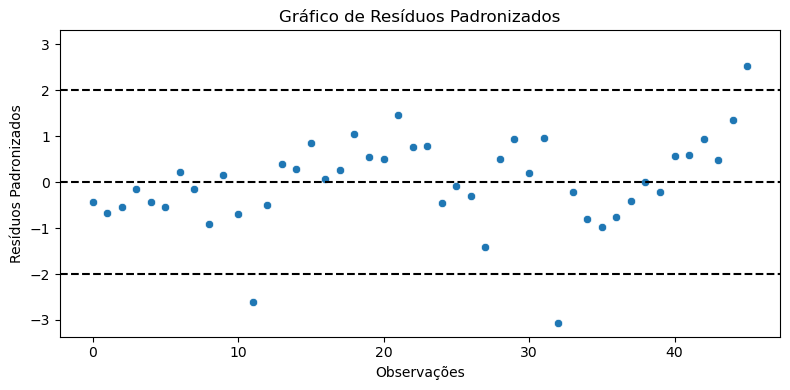

In [14]:
# Homocedasticidade (boa!): os pontos estão espalhados aleatoriamente ao redor da linha zero, sem formar padrões
# Heterocedasticidade (problema!): os resíduos formam um “funil” (abrindo ou fechando) ou algum padrão específico

grafico_residuos(resultado)

#### O que é o Teste de White?

O Teste de White é um dos testes estatísticos mais usados para verificar heterocedasticidade (ou seja, variação não constante dos resíduos). Ele complementa muito bem a análise visual do gráfico.

**Interpretação do Teste**
- Hipótese nula (H₀): Os resíduos têm variância constante (homocedasticidade)
- Hipótese alternativa (H₁): Os resíduos têm variância variável (heterocedasticidade)
- Se o p-valor < 0.05, rejeitamos H₀ → há evidência de heterocedasticidade

In [15]:
from statsmodels.stats.diagnostic import het_white
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

white_test = het_white(resultado.resid_pearson, resultado.model.exog)
print(dict(zip(labels, white_test)))

{'LM Statistic': 10.98510022754314, 'LM-Test p-value': 0.20254487068968238, 'F-Statistic': 1.450984834528977, 'F-Test p-value': 0.20864807181530834}


In [16]:
from statsmodels.stats.diagnostic import het_white
from IPython.display import display, HTML

# Rodar o teste de White
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(resultado.resid_pearson, resultado.model.exog)
white_dict = dict(zip(labels, white_test))

# Exibir resultados formatados
html_resultado = "<h4>📊 Teste de White para Homocedasticidade</h4><ul style='font-size:14px;'>"

for key in ['LM-Test p-value', 'F-Test p-value']:
    pval = white_dict[key]
    passou = pval >= 0.05
    cor = 'green' if passou else 'red'
    status = "✅ Homocedasticidade (variância constante)" if passou else "❗ Heterocedasticidade detectada"
    html_resultado += f"<li><strong>{key}</strong>: <span style='color:{cor}'>{pval:.4f}</span> → {status}</li>"

html_resultado += "</ul><p style='font-size:12px;'>* Considerando nível de significância de 5%.</p>"

display(HTML(html_resultado))

### Teste de Normalidade dos Resíduos
O Teste de Normalidade dos Resísudos será realizado por meio do histrograma da distribuição dos resíduos e do Teste de Shapiro-Wilk.

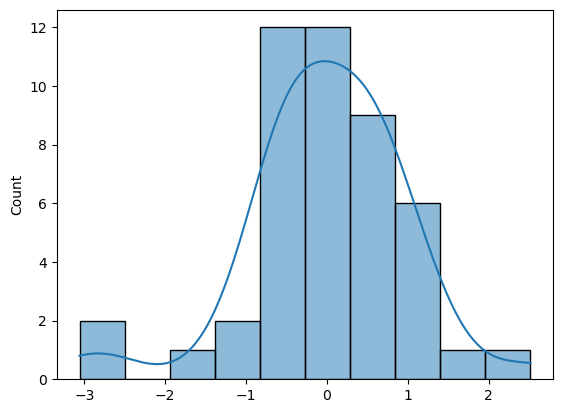

In [17]:
# Construção de histograma para avaliar a distribuição dos resíduos
sns.histplot(resultado.resid_pearson, kde=True);

In [18]:
# Realização de Teste de Hipóteses para avaliar Normalidade
from scipy.stats import shapiro
normalidade = shapiro(resultado.resid_pearson)
print('Estatística=%.3f, p-valor=%.3f\n' % (normalidade.statistic, normalidade.pvalue))

Estatística=0.945, p-valor=0.030



**Estatística do Teste de Shapiro-Wilk (Estatística=0.945):**

- A estatística do teste Shapiro-Wilk varia entre 0 e 1, onde valores próximos de 1 indicam que a distribuição dos dados está mais próxima de uma distribuição normal
- A estatística de 0.945 sugere que os resíduos de Pearson estão razoavelmente próximos de uma distribuição normal, mas não é conclusivo sem considerar o valor p

**Valor p (p-valor=0.030):**

- O valor p é usado para determinar a significância estatística do teste. Normalmente, um nível de significância (α) de 0.05 é usado como o limiar para decidir se rejeitamos ou não a hipótese nula
- Se o valor p é menor que 0.05, rejeitamos a hipótese nula, que afirma que os dados seguem uma distribuição normal. O valor p é 0.030 é menor que 0.05. Portanto, deve-se rejeitar a hipótese nula

**Conclusão Com base no resultado do teste de Shapiro-Wilk:**

- Hipótese Nula (H0): Os resíduos seguem uma distribuição normal
- Hipótese Alternativa (H1): Os resíduos não seguem uma distribuição normal

Como o valor p (0.030) é menor que 0.05, rejeita-se a hipótese nula. Como o valor de p é menor que o nível de significância de 5%, rejeitamos a hipótese nula, isso sugere que os resíduos **podem não seguir** uma distribuição normal.
